In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate

from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
np.random.seed(12345)

In [3]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-6            # m3 of isopropanol
m = 2.7677            # g of Raney Nickel
rho = 785             # kg/m³
M = 60.1              # g/mol
n0 = 1000*rho*V/M     # mol

In [4]:
n0

2.4816971713810316

In [5]:
k = 8.765e-6
b = 8.901e5
a = 1.234e4

In [6]:
def model(x, k, a, b, n0=n0):
    return k*(a*(n0 - x))/(1 + a*(n0 - x) + b*x)

In [7]:
def ode(t, x, k, a, b, n0):
    return np.array([
        model(x, k, a, b, n0)
    ])

In [8]:
t = np.linspace(0, 10000, 50)

In [9]:
sol = integrate.solve_ivp(ode, [t.min(), t.max()], y0=[0], args=(k, a, b, n0), t_eval=t)

In [10]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e+02 ...  9.796e+03  1.000e+04]
        y: [[ 0.000e+00  1.745e-03 ...  4.961e-02  5.033e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 62
     njev: 0
      nlu: 0

In [11]:
xi = sol.y[0,:]

In [12]:
r = ode(t, xi, k, a, b, n0).squeeze()

In [13]:
tn = (t + 5*np.random.normal(size=t.size)).round(1)

In [14]:
data = pd.DataFrame({"t": t, "tn": tn, "xi": xi, "r": r})

In [15]:
data["rinv"] = 1/data["r"]
data["A"] = (n0 - data["xi"])/V
data["B"] = data["xi"]/V
data["x1"] = data["xi"]/(n0 - data["xi"])
data["x2"] = np.log(1/data["x1"])

In [16]:
data["dxidt"] = data["xi"].diff()/data["tn"].diff()

In [27]:
coefs = np.polyfit(data["tn"], xi, 3)
data["xiP3"] = np.polyval(coefs, data["tn"])
data["rP3"] = np.polyval(np.polyder(coefs, m=1), data["tn"])

In [38]:
data["xiSG"] = signal.savgol_filter(data["xi"], 7, 3)
data["rSG"] = signal.savgol_filter(data["xi"], 7, 3, deriv=1, delta=np.diff(t)[0])

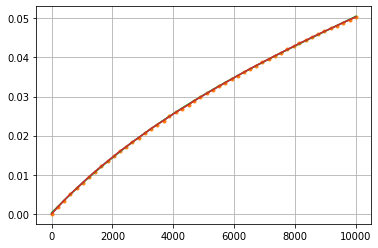

In [41]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["xi"])
axe.plot(data["tn"], data["xi"], linestyle="None", marker=".")
axe.plot(data["tn"], data["xiP3"])
axe.plot(data["tn"], data["xiSG"])
axe.grid()

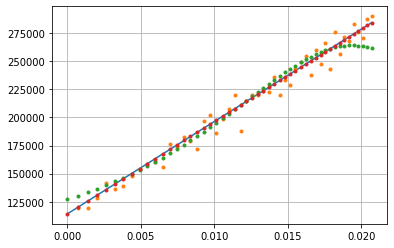

In [40]:
fig, axe = plt.subplots()
axe.plot(data["x1"], data["rinv"])
axe.plot(data["x1"], 1/data["dxidt"], linestyle="None", marker=".")
axe.plot(data["x1"], 1/data["rP3"], linestyle="None", marker=".")
axe.plot(data["x1"], 1/data["rSG"], linestyle="None", marker=".")
axe.grid()